In [26]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textwrap import wrap, fill
from matplotlib import rc

import os
import sys

from scipy.stats import gaussian_kde

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
debug=False
if debug:
    plt.rcParams["savefig.dpi"]=45
else:
    plt.rcParams["savefig.dpi"]=90
    

plt.rcParams["text.usetex"]=False
#plt.rcParams["text.latex.preamble"]=r"\usepackage{color}"


In [28]:
out_folder = "scorecards/"
os.makedirs(out_folder,exist_ok=True)

#Data

In [29]:
def normalizer(s):
    return (s-s.min())/(s.max()-s.min())

In [30]:
#Read inputs
df_original = pd.read_csv("df.csv").drop("iso3",axis=1).set_index("country").dropna()

df_with_sens = df_original.append(pd.read_csv("df_sensit_results.csv").drop("iso3",axis=1).set_index("country").dropna())

df_original.dropna(inplace=True) 

deriv_resilience=pd.read_csv("deriv.csv").rename(columns={"Unnamed: 0":"country"}).set_index("country")
deriv_risk =pd.read_csv("deriv_risk.csv").rename(columns={"Unnamed: 0":"country"}).set_index("country")

info = pd.read_csv("inputs_info.csv").set_index("key")

In [31]:
#upper and lower bounds
lower_bound = df_original.min()
upper_bound = df_original.max()

single_values_set = (lower_bound == upper_bound).replace(False,np.nan).dropna().index.tolist()

lower_bound[single_values_set]=info.ix[single_values_set,"lower"]
upper_bound[single_values_set]=info.ix[single_values_set,"upper"]

In [32]:
#Text for each subindicator
info = pd.read_csv("inputs_info.csv").set_index("key")
key_to_desc = info["descriptor"]

#ranks
rank=pd.read_csv("rankings.csv").set_index("country")
n=rank.values.max()

### countries to plot

In [33]:
if debug:
    country_list =[]
    #Sweden and the sensitivity analysis
    for c in df_with_sens.index:
        if "Malawi" not in c: continue
        else: country_list.append(c)
            
    country_list = ["Sweden","Croatia"]
        
else:
    country_list = df_with_sens.index#.tolist()[::-1] #from last to first

    
    

### keys to plot

In [34]:
risk_keys = ["v_shew","fa","protection","resilience"]
v_shew_keys = ["v","shew"]
resilience_keys = np.setdiff1d(deriv_resilience.columns,["v","fa","faref","v_s","avg_prod_k","shew","protection","T_rebuild_L","resilience","pi","H","alpha","income_elast"])



#params

In [35]:
smallfont = { 'size'   : 20}

font = {
    'size'   : 24}

fontlegend =font

boldfont = {      
     'weight': 'bold',
     'size'   : 24}

bigfont = {
     'weight': 'bold',
     'size'   : 30}

format_for_rank=lambda x :"{:1.0f}".format(x)

#drawing functions

###whole row

In [36]:
linewidth=1.5
height = .4

def fancy_round(x,n=2):
    """displays numbers with a given number of digits"""
    
    #special cases
    if np.isnan(x):
        return x
    
    if np.isinf(x):
        return (x)
    
    #number of digits before the dot in the original number
    if abs(x)<1:
        s=0
    else:
        s=int(np.log10(abs(x)))+1
    
    #output
    if s<n:
        return round(x,n-s)
    else:
        return int(round(x,n-s))
    
def draw_row(key,c,i,j,step):
    """descrption, distribution, rank and progress needed"""

    number_type = info["number_type"][key]
    xoc = df_with_sens.ix[c,key]

    is_single =  key in single_values_set

    if np.sign(step.ix[c,key])>0:
        color="blue"
        s=1
        difficulty = step.ix[c,key] /(upper_bound[key] -xoc)
    else:
        #color="red"
        color="blue"
        s=-1
        difficulty = step.ix[c,key]/(lower_bound[key]-xoc)

    step_color = "DarkOrange"
    if difficulty>10:
        step_color="DarKRed"
    if difficulty<1:
        step_color="DarkGreen"
    
    #format_for_der =lambda x :"{:1.2f} pt".format(x)

    if not is_single: 
        draw_distri(key,i,j,color,info.ix[key,"bandwith"],height,linewidth)
    
    anotate_distri(key,c,i,j,color)

    
    #formaters
    if number_type=="simple":
        format_for_step=lambda x :"{: g}".format(fancy_round(x))
    else:
        #format_for_step=lambda x :"{: g} pt".format(fancy_round(100*x))
        format_for_step=lambda x :"{: g}".format(fancy_round(100*x))
    
    #Progress needed (with actual minus sign)
    plt.text(j+1.85,i,format_for_step(step.ix[c,key]).replace("-","−"),fontdict=font,horizontalalignment='center',color=step_color)
         
    '''if not is_single:
        #rank
        r=rank.ix[df_with_sens.ix[c,"original_country"],key]
        ar=.5*(r*(s+1) + (1+n-r)*(1-s))
        the_sring = format_for_rank(ar)
    else:
        the_sring = " "
    plt.text(1.75,i,the_sring,fontdict=font,horizontalalignment='center')''' 

    return i+.8

###distribution

In [37]:
t=np.linspace(0,1,100)

def draw_distri(key,i,j,color,bandwith,height,linewidth):
    """distribution"""
   
    x = (df_original[key]-lower_bound[key])/(upper_bound[key]-lower_bound[key])
    #all countries distribution
    y=gaussian_kde(x, bandwith)(t)
    y=height*y/y.max() 
    plt.plot(j+t, i+y,color=color,linewidth=linewidth)
    
    

def anotate_distri(key,c,i,j,color,other_description=None): 
    """dot where the country stands, bounds, and description of sub-indicator"""
    number_type=info["number_type"][key]
    
    legend_mode = other_description is not None
    
    
    
    if number_type=="percent":
        format_for_val=lambda x :"{:2.0f}%".format(100*x)
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="small_percent":
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
    elif number_type=="simple":
        format_for_val=lambda x :"{:2.0f} yr".format(x)
        format_for_bound=lambda x :"{:2.0f}".format(x)
    elif number_type=="resilience":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="risk":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)


    #Grey line
    plt.plot(j+t, i+0*t, color="gray",linewidth=1)
    
    if legend_mode:
        lb = "min"
        ub = "max across\ncountries"
    else:
        lb = format_for_bound(lower_bound[key])
        ub = format_for_bound(upper_bound[key])
        
    #bounds
    plt.text(j+0-.05, i, lb,fontdict=smallfont,horizontalalignment="right",verticalalignment="center")
    plt.text(j+1+.05, i, ub,fontdict=smallfont,horizontalalignment="left" ,verticalalignment="center")
        
    #performance of this country 
    v = df_with_sens.ix[c,key]
    x = (v-lower_bound[key])/(upper_bound[key]-lower_bound[key])

    if legend_mode:
        v_ = "value in\n"+c
    else:
        v_ = format_for_val(v)
        
    plt.text(j+x, i-.1,v_,color="black",fontdict=font,horizontalalignment="center",verticalalignment="top")
    plt.scatter(j+x,i,s=50,c="black",zorder = 20)
    
    #Description
    if other_description is None:
        plt.text(j-.35, i, info.ix[key,"descriptor"],fontdict=font,horizontalalignment='right')      
    else:
        plt.text(j-.35, i, other_description,fontdict=font,horizontalalignment='right')  

###separator and titles

In [38]:
def draw_seprarator(i,j):
    """horizontal grey line"""
    sep_steps=.08
    i+=sep_steps
    ex=j+np.array([-2,2.5])
    sep_i  = i-0.35
    plt.plot(ex, sep_i+0*ex, color="#aaaaaa",linewidth=1,clip_on=False)
    return i+sep_steps,sep_i
 

In [39]:
def draw_conector(gauche,milieu,droite,bas,haut):
    plt.plot([gauche,milieu],[bas, bas],color="gray")
    plt.plot([milieu,milieu],[bas ,haut],color="gray")
    plt.plot([milieu,droite],[haut ,haut],color="gray")

In [40]:
def write_titles(i,j,second_title):
    #titles
    #plt.text(5.5,i-.15,"Impact \non resilience",fontdict=font, horizontalalignment='center')
    #plt.text(1.75,i-.15,"Rank",fontdict=font, horizontalalignment='center')
    plt.text(j+1.85,i-.15,second_title,fontdict=font, horizontalalignment='center')
   

##Zones

In [41]:
format_=lambda x :"{:g}%".format(fancy_round(100*np.abs(x)))

In [42]:
def draw_other_zone(keyname,resilience_keys,c,i,j,steps_needed,improve_obj):
    #resilience drivers
    for key in resilience_keys:
        i=draw_row(key,c,i,j,steps_needed)

    if False:    
        #separator
        i,resi_sep_i= draw_seprarator(i,j)

        #driver
        draw_distri(keyname,i,j,"Blue",.3,height,linewidth)
        anotate_distri(keyname,c,i,j,"Blue")
    else:
        resi_sep_i=i-.3
        
        
    if np.sign(improve_obj)<0:
        improve_word = "improve\n"
    else:
        improve_word = "reduce\n"


    write_titles(i,j,"To "+improve_word+info.ix[keyname,"descriptor"].replace("Asset ","").lower()+"\nby "+format_(improve_obj))
           
    return i,resi_sep_i

In [43]:
def draw_risk_zone(risk_keys,c,i,j,steps_needed):
    flag= True
    #risk drivers
    for key in risk_keys:
        if key in ["v_shew", "resilience"]:
            if flag:
                i_bot_in_risk = i
                flag=False
            else:
                i_top_in_risk = i   
        i=draw_row(key,c,i,j,steps_needed)    

    #separator
    i,risk_sep_i= draw_seprarator(i,j)

    #risk
    draw_distri("risk",i,j,"Blue",.3,height,linewidth)
    anotate_distri("risk",c,i,j,"Blue")

    write_titles(i,j,"Change needed\nto reduce\nrisk by 10%")  
    return i, risk_sep_i,i_bot_in_risk,i_top_in_risk

In [44]:
def report_current_country(c):
    #report progress
    clear_output()
    print(c)
    sys.stdout.flush()    


###Caption

In [45]:
caption = """
This scorecard 
shows the risk to welfare in {country} (expected welfare losses in percent of GDP), and 
its drivers: hazard (captured with protection level), exposure, asset 
vulnerability, and resilience. //

Drivers are ranked according to their efficacy to reduce 
risk, from the most to the least promising. Limited improvements in the 
drivers at the top of the list can substantially reduce risk, 
while large improvements would be required in drivers at the 
bottom to obtain a similar reduction. This information is quantified in 
the right-most column, which indicates how much each driver needs 
to change to reduce risk by 10%. 
For each driver, the scorecard provides the 
distribution of values across all countries with the minimum and the 
maximum, to indicate where {country} stands with respect to the 89 
other countries. //

The number is green if the corresponding change is achievable without exceeding the best 
performance among all countries in the sample. It is orange if one tenth 
of the change is achievable without exceeding the best performance. 
Otherwise, the number is red. 

On the right, asset vulnerability is broken down 
into 2 sub-indicators, and socio-economic resilience into 14 sub-indicators. //

Similarly to drivers, sub-indicators are ranked according to their efficacy to improve 
resilience by {resi_needed} or reduce asset vulnerability by {vshew_needed}. //
""".replace("\n","").replace("//","")

#actual drawing

Sweden $(\eta=2.0)$


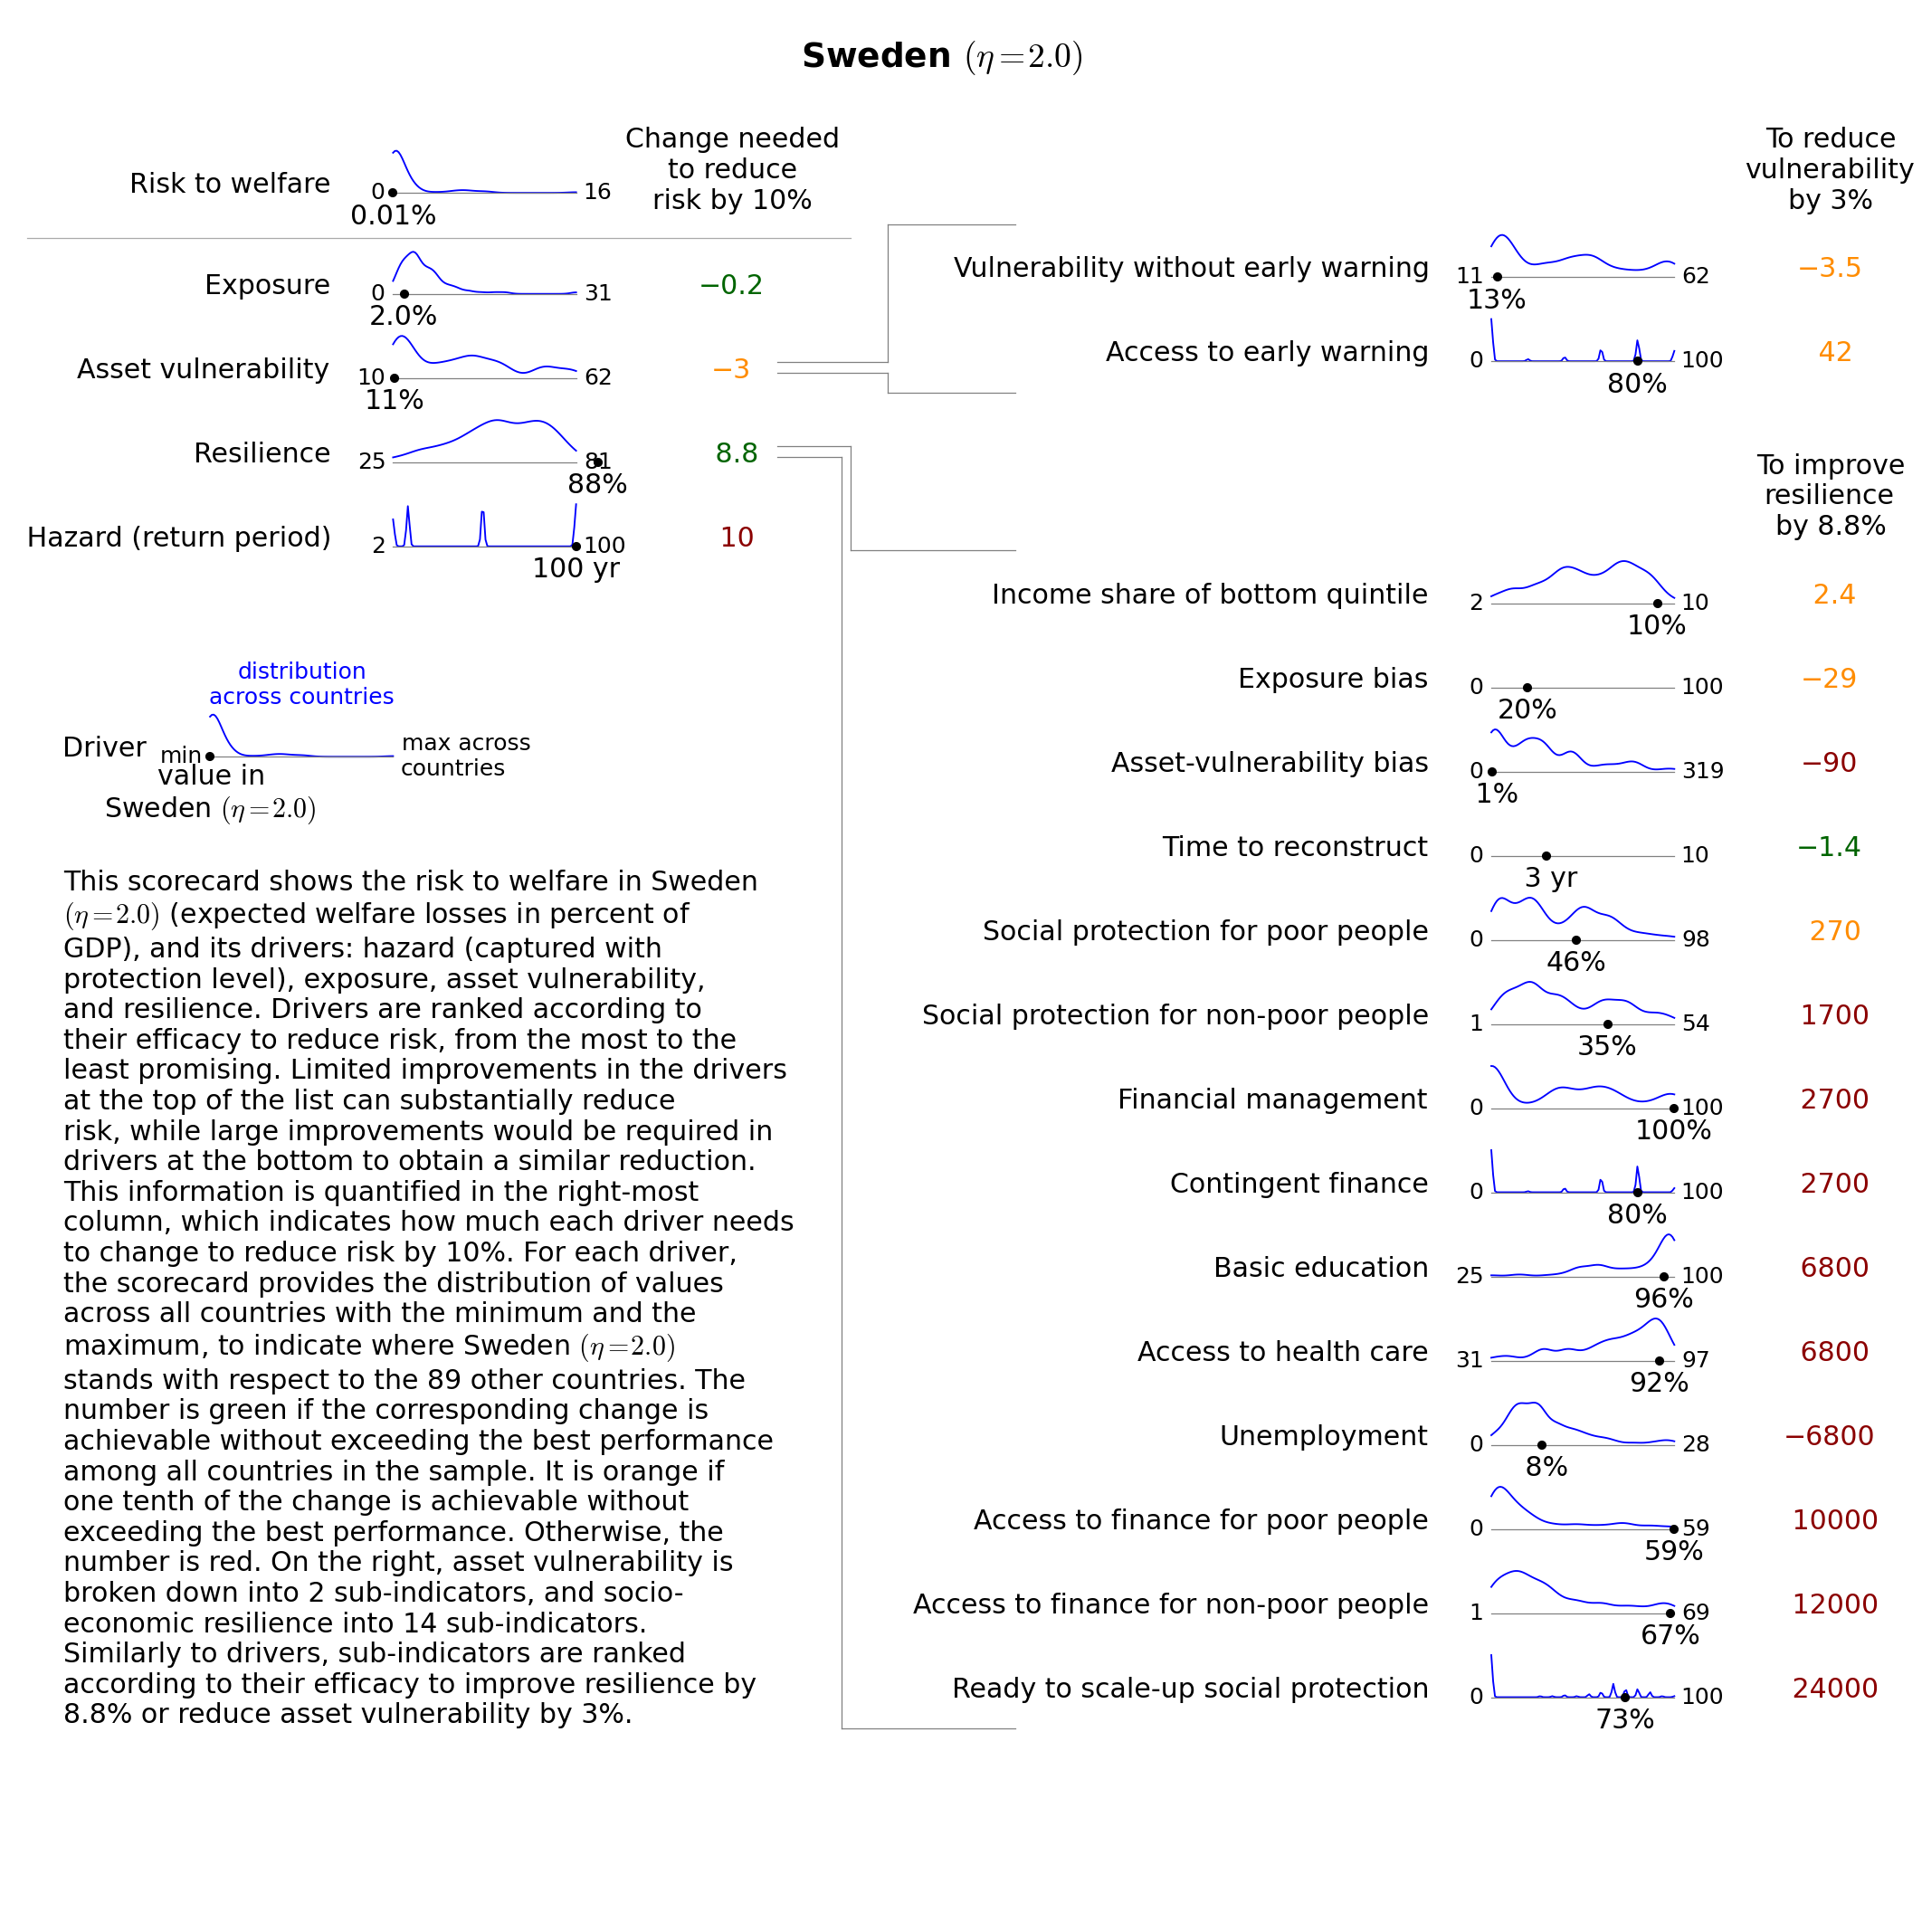

In [46]:
for c in country_list:
    report_current_country(c)
    #new figure
    fig=plt.figure(figsize=(29,30))
    i=0
    j=6
    #sort keys
    risk_keys       = deriv_risk.abs().ix[c][risk_keys      ].order(ascending=True).index.tolist()
    v_shew_keys     = deriv_risk.abs().ix[c][v_shew_keys    ].order(ascending=True).index.tolist()
    resilience_keys = deriv_risk.abs().ix[c][resilience_keys].order(ascending=True).index.tolist()

    #steps wanted
    step_wanted_in_risk = -1/10 * df_with_sens.ix[c,"risk"]
    step_wanted_in_resilience = -step_wanted_in_risk/deriv_risk["resilience"][c]
    step_wanted_in_vshew = -step_wanted_in_risk/deriv_risk["v_shew"][c]

    #resilience zone should be in the bottom
    if next(key for key in risk_keys if key in ["resilience","v_shew"]) =="resilience":
        
        n_,k_,s_,o_    ="resilience",resilience_keys,-step_wanted_in_resilience/deriv_resilience,step_wanted_in_resilience
        n__,k__,s__,o__="v_shew",v_shew_keys,step_wanted_in_risk/deriv_risk,step_wanted_in_vshew
        
         
    #v_shew is in the bottom
    else:
        n__,k__,s__,o__ ="resilience",resilience_keys,-step_wanted_in_resilience/deriv_resilience,step_wanted_in_resilience
        n_ ,k_ ,s_ ,o_  ="v_shew",v_shew_keys,step_wanted_in_risk/deriv_risk,step_wanted_in_vshew

        
    #Resilience and vulnerability zones
    i_bottom_bot_zone = i
    i,bot_sep_i= draw_other_zone(n_,k_,c,i,j,s_,o_)

    i+=1.5
    i_bottom_top_zone = i
    i,top_sep_i= draw_other_zone(n__,k__,c,i,j,s__,o__)
    
    i-=4-0.639999999999997
    
    
    j=-1.8
    
    #Caption
    
    plt.text(j,0-.3,fill(caption.format(
                country=c,vshew_needed=format_(step_wanted_in_vshew),resi_needed=format_(step_wanted_in_resilience))
                         ,52),va="bottom",ha="left",fontdict=fontlegend)
    
    #Legend
    ii = i - 2
    
    #plt.text(j,ii+1,"Legend",fontdict=boldfont,ha="left") 
    j+=.8
    draw_distri("risk",ii,j,"Blue",.3,height,linewidth)
    anotate_distri("risk",c,ii,j,"Blue","Driver")
    plt.text(j+.5,ii+.5,"distribution\nacross countries",fontdict=smallfont,color="blue",ha="center")
  
    #risk zone
    j=0
    i, risk_sep_i,i_bot_in_risk,i_top_in_risk =draw_risk_zone(risk_keys,c,i,j,step_wanted_in_risk/deriv_risk)
    
    #Conectors
    h_entonoir = .05
    w_entonoir = .05

    draw_conector(2.1,2.5           ,3.4,i_bot_in_risk+.1+h_entonoir,bot_sep_i)
    draw_conector(2.1,2.5-w_entonoir,3.4,i_bot_in_risk+.1-h_entonoir,i_bottom_bot_zone-.3)
    
    draw_conector(2.1,2.7  ,3.4,i_top_in_risk+.1+h_entonoir,top_sep_i)
    draw_conector(2.1,2.7  ,3.4,i_top_in_risk+.1-h_entonoir,i_bottom_top_zone-.3)
     
    #Country name
    plt.text(3,i+1.2,c,fontdict=bigfont,horizontalalignment="center")
    
    #Settings
    plt.axis('off');
    plt.xlim(xmin=-2)
    
    #Saving
    #subfolder = "elast_"+str( df_with_sens.ix[c,"income_elast"])+"/"
    os.makedirs(out_folder,exist_ok=True)
    fig_format = ".png" if debug else ".eps"
        
    plt.savefig(out_folder+c.lower().replace(" ","_").replace("\\","")+fig_format,bbox_inches="tight")
    if not debug:
        if not c == country_list[-1]:
            plt.close()




In [47]:
#merges all the eps scoreacards into one big pdf file
#implements http://stackoverflow.com/questions/7102090/combining-pdf-files-with-ghostscript-how-to-include-original-file-names

if not debug:
    import glob
    from subprocess import call, Popen

    #goes to the write directory
    glob.os.chdir("scorecards/")

    command= ""
    i=1
    for name in glob.glob("*.eps"):
        command+="({name}) run [ /Page {page} /Title ({name}) /OUT pdfmark \n".format(name=name,page=i)
        i+=1

    with open("control.ps", "w") as text_file:
        text_file.write(command)

    #merges all eps to a PDF
    p=Popen("gswin64c -dEPSFitPage -sDEVICE=pdfwrite -o scorecards.pdf control.ps");
    print("Merging scorecards....")
    #transforms all the EPS in PNG
    q=Popen("mogrify -density 150 -format png *.eps");
    print("Converting scorecards....")

    p.communicate()
    q.communicate()
    print("... both done")
    glob.os.chdir("..")

Merging scorecards....
... both done
